In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from Python.tigre.algorithms.single_pass_algorithms import FDK
from Python.tigre.utilities.io.VarianDataLoader import ScanParams, ReconParams, read_recon_xml, read_scan_xml, read_varian_geometry, load_projections

In [ ]:
mydir = "C:/CBCT_Scatter_Removal_Project/data/clinical/4100758/2021-07-06_101037/11528a87-b894-4239-846d-45d8fd1efeda"

In [ ]:
scan_params = ScanParams(mydir, xml_reader=read_scan_xml)
recon_params = ReconParams(mydir, xml_reader=read_recon_xml)
geometry = read_varian_geometry(scan_params, recon_params)
angular_threshold = scan_params.calculate_angular_threshold()

proj_data = load_projections(mydir, angular_threshold)

In [ ]:
def abs_diff(a,b):
    return np.abs(a-b)

def prct_diff(a,b):
    abs = abs_diff(a,b)
    return abs/(np.abs(a)+1e-6)

In [14]:
recon = np.load('./data/recon_sks.npy',allow_pickle=True)


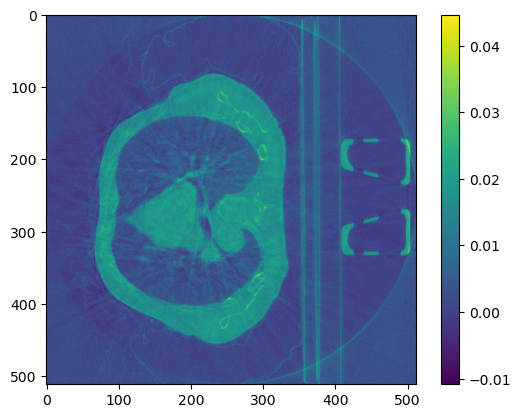

In [15]:
plt.imshow(recon[20])
plt.colorbar()

In [21]:
matfile=h5py.File('C:/CBCT_Scatter_Removal_Project/4100758_proj_recon.mat','r')
print(list(matfile.keys()))
matproj = np.array(matfile.get('proj_lg'))
matproj = np.squeeze(matproj)
matproj = np.transpose(matproj,axes=(0,2,1))
matfile.close()

['proj', 'proj_dps', 'proj_lg', 'recon']


In [22]:
matrec = FDK(matproj,geometry,angles,verbose=True
             )

FDK: applying detector offset weights


c:\Users\MedPhys\anaconda3\envs\tigre\lib\site-packages\tigre\utilities\filtering.py:73: UserWarning: no filter selected, using default ram_lak
  warnings.warn("no filter selected, using default ram_lak")


In [35]:
matrec[matrec<0]=0
recon[recon<0]=0

In [40]:
from Python.tigre.utilities.mask_CBCT import maskCBCT

In [43]:
abs = abs_diff(maskCBCT(matrec),maskCBCT(recon))
np.mean(abs)

0.00014697755

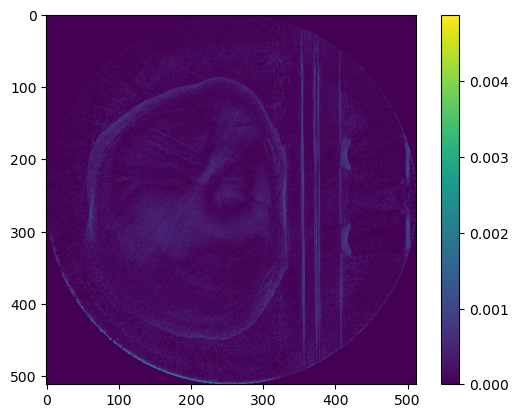

In [45]:
plt.imshow(abs[44])
plt.colorbar()